# <center> PROCESAMIENTO DIGITAL DE SEÑALES DE AUDIO</center>
## <center> Síntesis por cascada de formantes</center>      

In [ ]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd

### Descripción

Este ejercicio sirve para estudiar el **modelo del mecanismo de producción de voz**, a través de la síntesis de sonidos vocálicos.

La idea consiste en generar un **tren de impulsos** de banda limitada como fuente de excitación glotal, y luego filtrarlo sucesivamente mediante múltiples **resonadores** con frecuencias y anchos de banda correspondientes a las distintas **formantes** de una vocal. Por último, se aplica un filtro pasa-altos como modelo de radiación.


### Cómo correr el notebook
Se puede bajar y correr el notebook de forma local en una computadora.

O también se puede correr en Google Colab usando el siguiente enlace. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/notebooks/audioDSP-formant_synthesis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Resonador

A continuación se define una función que implementa un filtro resonador. Estudie sus parámetros de entrada. 

In [ ]:
def resonator(x, fs, res_freq, res_bw):
    """
    second order difference equation digital resonator

    Parameters
    ----------
    x (numpy array)  : input audio waveform
    fs (int)         : sampling frequency in Hz
    res_freq (float) : resonator frequency in Hz
    res_bw (float)   : resonator bandwith in Hz

    Returns
    -------
    y (numpy array) : filtered audio waveform

    """

    C = -math.exp(-2*math.pi*res_bw/fs)
    B = 2*math.exp(-math.pi*res_bw/fs)*math.cos(2*math.pi*res_freq/fs)
    A = 1-B-C

    T = x.shape[0]
    # add two initial null values to x
    x = np.insert(x, 0, 0)
    x = np.insert(x, 0, 0)
    # output signal
    y = np.zeros((T+2, 1))

    # filtering difference equation
    for ind in range(2, T+1):
        y[ind] = A*x[ind] + B*y[ind-1] + C*y[ind-2]

    y = y[2:]

    return y

### Síntesis de formantes

La siguiente función implementa la síntesis del sonido de una vocal mediante formantes en cascada.

Complete el código que se proporciona a continuación y siguiendo los siguientes pasos. 

1. Complete las instrucciones necesarias para generar el tren de pulsos (con muestras en 0 y 1).
2. Complete las instrucciones necesarias para aplicar los resonadores en cascada para la formante correspondiente.
3. Complete las instrucciones necesarias para implementar el filtro pasa-altos del modelo de radiación como una diferencia de primer orden. 

In [15]:
def formant_synthesis(fs=44100, f0=100, dur=1, vowel='a'):
    """
    formant synthesizer

    Parameters
    ----------
    fs (int)       : sampling frequency in Hz
    f0 (float)     : fundamental frequency in Hz
    dur (float)    : vowel duration in seconds
    vowel (string) : character to set the vowel: 'a' 'e' 'i' 'o' 'u'

    Returns
    -------
    y (numpy array) : synthetized audio waveform

    """

    # period in samples
    T0 = int(round(fs/f0))
    # time instants
    t = np.linspace(0, dur, fs*dur)
    T = len(t)

    # voicing source
    vs = np.zeros((T, 1))
    # impulse train
    vs[int(math.floor(T0/2))::T0] = 1
    
    # low-pass resonator filter (res_freq = 0 Hz, res_bw = 100 Hz)
    vs = resonator(vs, fs, 0, 4*f0)
    # amplitude gain in dB
    vsGain = 35
    # set amplitude gain
    vs *= 10**(vsGain/20)

    # formants definition
    # number of formants for each vowel
    num_formants = 4
    # formants data
    # freq1 bw1 freq2 bw2 freq3 bw3 freq4 bw4
    # reference: http://www.sinfomed.org.ar/mains/temas/voctexto.htm
    formants_data = {
        'a': [830, 105, 1350, 106, 2450, 142, 3655, 197],
        'e': [430, 75, 2120, 106, 2628, 140, 3610, 180],
        'i': [290, 63, 2295, 103, 2915, 174, 3645, 124],
        'o': [510, 83, 860, 105, 2480, 156, 3485, 170],
        'u': [335, 80, 720, 112, 2380, 208, 3355, 150]
    }
    # select formants corresponding to given vowel
    try:
        formants_values = formants_data[vowel]
    except KeyError as e:
        print('Error: vowel string not found. Using \'a\' as input parameter. KeyError: ' + str(e))
        formants_values = formants_data['a']

    # cascade filters vocal tract simulation
    y = vs
    for idx in range(num_formants):
        y = resonator(y, fs, formants_values[2*idx], formants_values[2*idx+1])

    # radiation characteristic
    # for i in range(1, len(y)):
    #     y[i] = y[i] - y[i-1]

    y = y[1:-1] - y[:-2]

    # normalization
    y = y*0.99/np.max(np.abs(y))

    return y, vs, t

### Prueba de la síntesis de formantes

El código que se proporciona a continuación sintetiza una vocal con la función implementada anteriormente. Además se grafica la forma de onda de una trama de la excitación, así como la forma de onda y el espectro de una trama de la señal resultante.

Ejecute el código y analice lo siguiente. 

1. Observe que la señal usada como excitación para el banco de filtros resonantes es un tren de pulsos limitado en frecuencia. ¿Es esto coherente con el modelo planteado en clase? ¿Cómo debería cambiar el ancho de banda de la excitación con la intensidad de la señal?
2. Analice la forma de onda de la señal resultante. ¿Es una señal periódica? ¿Cuál es su período?
3. Analice el espectro de la señal resultante. ¿Logra distinguir con claridad la ubicación de las dos primeras formantes?

#### Síntesis de formantes

In [16]:
xv, vs, t = formant_synthesis(vowel='a')

#### Cálculo de espectro y gráficas

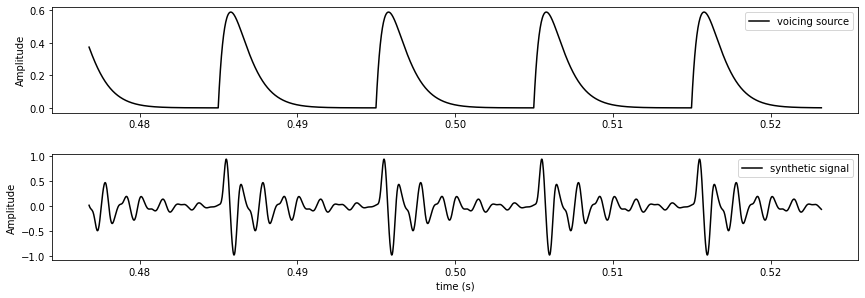

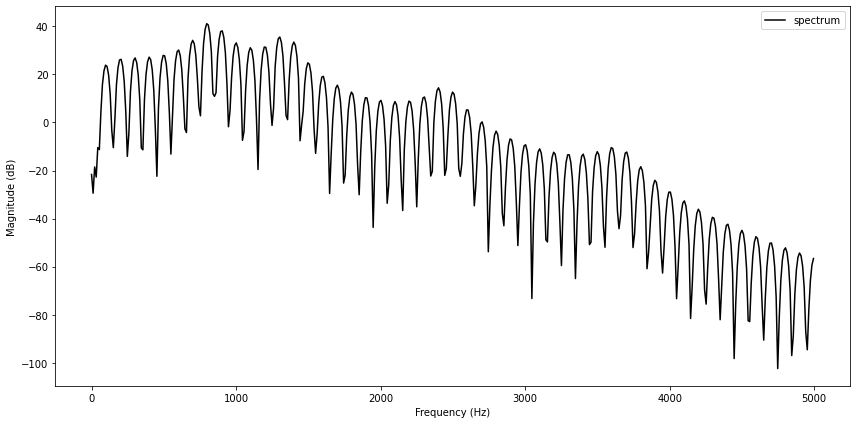

In [17]:
# sampling rate
sr = 44100
# fundamental frequency
f0 = 100
# duration
dur = 1
# window samples
N = 2**math.ceil(math.log2(round(4*sr/f0)))
# nfft (fft samples)
nfft = 2 * N
# maximum frequency
fmax = 5000
# frame indexes
tmid = round(dur/2*sr)
ind_ini = tmid - int(N/2)
ind_end = tmid + int(N/2)
# smoothing window
window = signal.windows.get_window('hann', N)

# signal frame
frame = xv[ind_ini:ind_end]

# windowed signal frame
frame_win = frame[:, 0] * window
# spectrum of the signal frame
Xv = np.fft.fft(frame_win, nfft)
# magnitude spectrum
magXv = np.abs(Xv)    

# frequency values
f = np.fft.fftfreq(nfft) * sr
ind_fmx = np.argwhere(f > fmax)[0][0]

plt.figure(figsize=(12,12))
plt.subplot(6, 1, 1)
plt.plot(t[ind_ini:ind_end], vs[ind_ini:ind_end], 'k', label='voicing source')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(6, 1, 2)
plt.plot(t[ind_ini:ind_end], xv[ind_ini:ind_end], 'k', label='synthetic signal')
plt.ylabel('Amplitude')
plt.xlabel('time (s)')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(f[:ind_fmx], 20 * np.log10(magXv[:ind_fmx]), 'k', label='spectrum')
plt.legend()
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

### Síntesis de vocales

El código que se proporciona a continuación sintetiza las cinco vocales y guarda un archivo de audio para cada una. Además se grafica la forma de onda y el espectro de cada señal de audio.

Ejecute el código y siga los siguientes pasos. 

1. Evalúe auditivamente el resultado de la síntesis. ¿Logra diferenciar el sonido de cada vocal?
2. Compare la forma de onda de cada vocal. ¿Logra distinguir las diferencias dadas por las diferentes formantes?
3. Compare el espectro de cada vocal. ¿Logra distinguir con claridad las diferencias en la ubicación de las dos primeras formantes?
4. Considere el mapa de formantes presentado en clase. ¿La ubicación de las formantes sigue esa caracterización? 
5. Nuevamente evalúe auditivamente el resultado de la síntesis. ¿Qué limitantes identifica en la síntesis que hacen que el sonido sea poco realista?

In [18]:
# sampling rate
sr = 44100
# formants
vowels = ['a', 'e', 'i', 'o', 'u']
# list of numpy arrays (audio waveforms)
s = []

# test formant synthesis
for v in vowels:
    xv, _, _ = formant_synthesis(vowel=v)
    # save for ploting
    s.append(xv)
    # write audio file (44100, 16 bits)
    wxv = xv * 32767
    wavfile.write('./' + v +'.wav', sr, wxv.astype(np.int16))

#### Evaluación auditiva de la síntesis

In [19]:
sr, data = wavfile.read('a.wav')
ipd.Audio(data, rate=sr)

In [10]:
sr, data = wavfile.read('e.wav')
ipd.Audio(data, rate=sr)

In [ ]:
sr, data = wavfile.read('i.wav')
ipd.Audio(data, rate=sr)

In [ ]:
sr, data = wavfile.read('o.wav')
ipd.Audio(data, rate=sr)

In [ ]:
sr, data = wavfile.read('u.wav')
ipd.Audio(data, rate=sr)

#### Graficar forma de onda

Text(0.5, 0, 'Time (samples)')

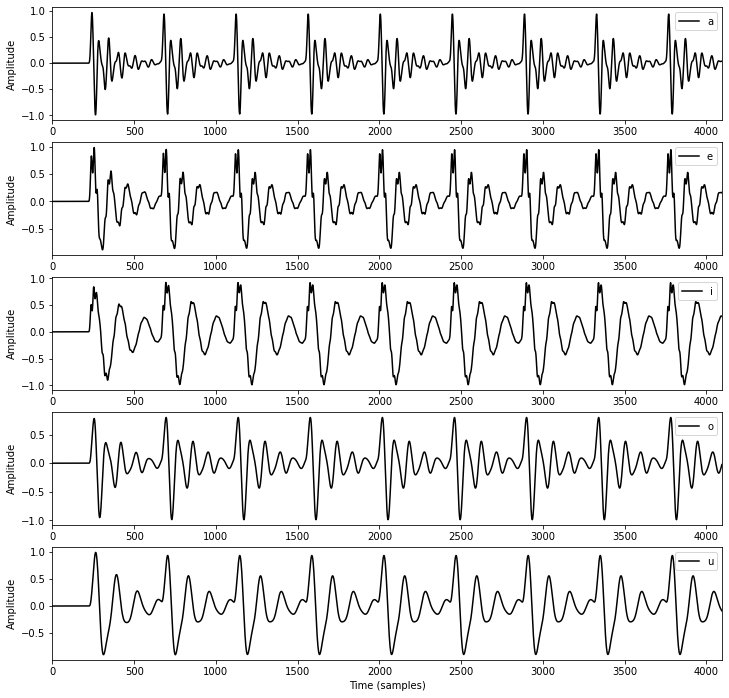

In [20]:
# number of samples to plot
ns = 4096
# number of vowels
num_vowels = len(vowels)

plt.figure(figsize=(12,12))
for index, v in enumerate(vowels):
    xv = s[index]
    plt.subplot(num_vowels, 1, index+1)
    plt.plot(xv[:ns], 'k', label=v)
    plt.legend()
    plt.xlim([0, ns])
    plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')

#### Calcular y graficar espectro de una trama de señal

In [21]:
# window samples
f0 = 100
N = 2**math.ceil(math.log2(round(4*sr/f0)))
# nfft (fft samples)
nfft = 2 * N
# maximum frequency
fmax = 5000
# duration
dur = 1
# frame indexes
tmid = round(dur/2*sr)
ind_ini = tmid - int(N/2)
ind_end = tmid + int(N/2)
# smoothing window
window = signal.windows.get_window('hann', N)

# list of numpy arrays (spectrums)
Xs = []

for index, v in enumerate(vowels):
    # waveform
    xv = s[index]
    # signal frame
    frame = xv[ind_ini:ind_end]
    # windowed signal frame
    frame_win = frame[:, 0] * window
    # spectrum of the signal frame
    Xv = np.fft.fft(frame_win, nfft)
    # save spectrum
    Xs.append(Xv)

# frequency values
f = np.fft.fftfreq(nfft) * sr
ind_fmx = np.argwhere(f > fmax)[0][0]

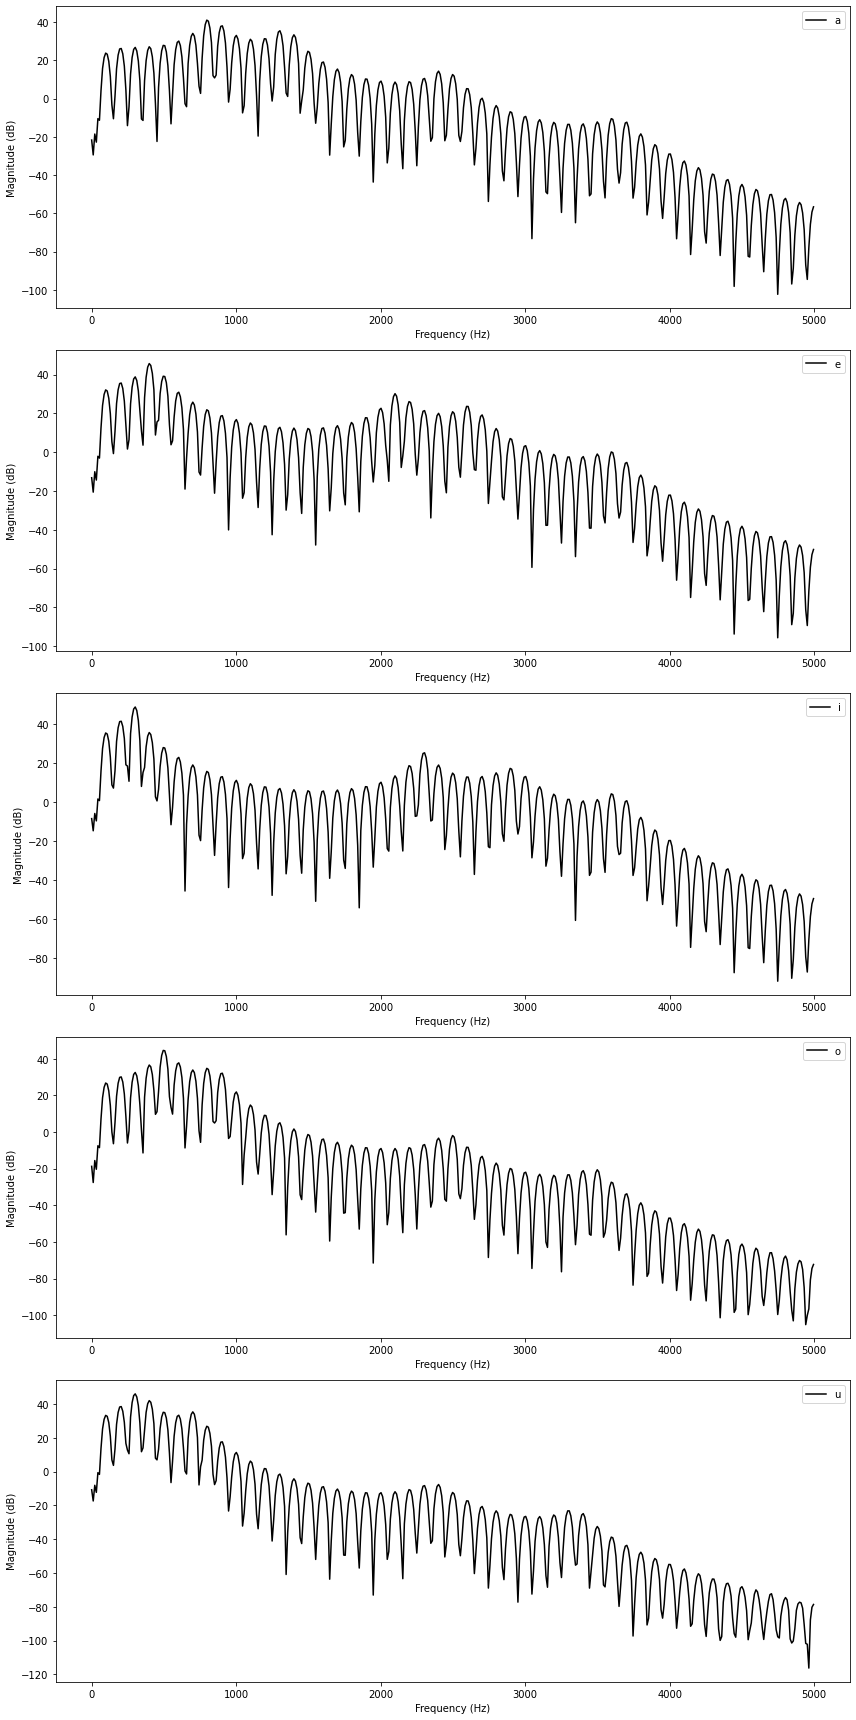

In [22]:
plt.figure(figsize=(12,24))
for index, v in enumerate(vowels):
    # spectrum
    Xv = Xs[index]
    # magnitude spectrum
    magX = np.abs(Xv)    
    plt.subplot(num_vowels, 1, index+1)
    plt.plot(f[:ind_fmx], 20 * np.log10(magX[:ind_fmx]), 'k', label=v)
    plt.legend()
    plt.ylabel('Magnitude (dB)')
    plt.xlabel('Frequency (Hz)')
plt.tight_layout()